![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<Axes: xlabel='Year', ylabel='Mileage'>

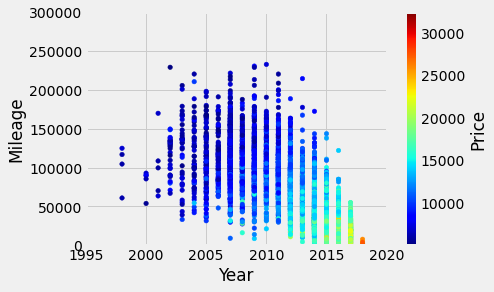

In [5]:
# Celda 1

# Visualización de la información
# Gráfica del salario, años y hits
plt.style.use('fivethirtyeight')
data.plot(kind='scatter', x='Year', y='Mileage', c='Price', colormap='jet', xlim=(1995, 2020), ylim=(0, 300000))

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

Esta gráfica muestra la relación entre el año de fabricación del automóvil (en el eje x), la cantidad de millas recorridas (en el eje y) y el precio del automóvil (representado por el color). Las tonalidades más cálidas indican precios más altos, mientras que las tonalidades más frías indican precios más bajos.

In [6]:
# Resumen estadístico de la variable objetivo
y.describe()

count    10495.000000
mean     14538.403716
std       3922.420961
min       5002.000000
25%      11999.000000
50%      15000.000000
75%      16999.000000
max      32444.000000
Name: Price, dtype: float64

La base de datos tiene un regisstro de 10,495 automóviles. El precio medio de los automóviles es de 14,538. La desviación estándar es de aproximadamente 3,922, lo que indica la dispersión de los precios alrededor de la media. El precio mínimo registrado es de 5,002, mientras que el precio máximo es de 32,444. El 25% de los precios son menores o iguales a 11,999. El 50% de los precios son menores o iguales a 15,000, lo que coincide con la mediana. El 75% de los precios son menores o iguales a 16,999.

El siguiente código construye un árbol de decisión de forma manual y calcula el RMSE y MAE en el conjunto de prueba.

In [7]:
def calcular_errores(y_real, y_pred):
    mse = np.mean(np.square(y_real - y_pred))
    mae = np.mean(np.abs(y_real - y_pred))
    return np.sqrt(mse), mae


def dividir_datos(X, y, indice_caracteristica, valor_division):
    indices_izquierdos = X[:, indice_caracteristica] <= valor_division
    indices_derechos = ~indices_izquierdos
    return X[indices_izquierdos], y[indices_izquierdos], X[indices_derechos], y[indices_derechos]


def encontrar_mejor_division(X, y):
    mejor_mse = float('inf')
    mejor_indice = None
    mejor_valor_division = None

    for indice_caracteristica in range(X.shape[1]):
        valores_unicos = np.unique(X[:, indice_caracteristica])
        for valor in valores_unicos:
            X_izq, y_izq, X_der, y_der = dividir_datos(X, y, indice_caracteristica, valor)
            mse_izq = np.mean(np.square(y_izq - np.mean(y_izq)))
            mse_der = np.mean(np.square(y_der - np.mean(y_der)))
            mse_total = mse_izq + mse_der

            if mse_total < mejor_mse:
                mejor_mse = mse_total
                mejor_indice = indice_caracteristica
                mejor_valor_division = valor

    return mejor_indice, mejor_valor_division


def construir_arbol(X, y, profundidad_maxima):
    if profundidad_maxima == 0 or len(X) <= 1:
        return np.mean(y)

    mejor_indice, mejor_valor_division = encontrar_mejor_division(X, y)
    X_izq, y_izq, X_der, y_der = dividir_datos(X, y, mejor_indice, mejor_valor_division)

    subarbol_izq = construir_arbol(X_izq, y_izq, profundidad_maxima - 1)
    subarbol_der = construir_arbol(X_der, y_der, profundidad_maxima - 1)

    return {'indice_caracteristica': mejor_indice, 'valor_division': mejor_valor_division,
            'subarbol_izq': subarbol_izq, 'subarbol_der': subarbol_der}


def predecir_arbol(arbol, muestra):
    if isinstance(arbol, float):
        return arbol
    
    indice_caracteristica = arbol['indice_caracteristica']
    valor_division = arbol['valor_division']

    if muestra[indice_caracteristica] <= valor_division:
        return predecir_arbol(arbol['subarbol_izq'], muestra)
    else:
        return predecir_arbol(arbol['subarbol_der'], muestra)


arbol_decision = construir_arbol(X_train.values, y_train.values, profundidad_maxima=3)


y_pred_test = np.array([predecir_arbol(arbol_decision, muestra) for muestra in X_test.values])


rmse_test, mae_test = calcular_errores(y_test.values, y_pred_test)

print("Error Cuadrático Medio (RMSE) en el conjunto de prueba:", rmse_test)
print("Error Absoluto Medio (MAE) en el conjunto de prueba:", mae_test)


Error Cuadrático Medio (RMSE) en el conjunto de prueba: 2620.020265048591
Error Absoluto Medio (MAE) en el conjunto de prueba: 2006.1209850552918


Los valores obtenidos indican que el modelo tiene un rendimiento aceptable en la predicción del precio de los automóviles en el conjunto de prueba, aunque podrían mejorarse. 

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

Para crear el modelo, se puede generar un conjunto de muestras aleatorias con reemplazo utilizando la función `np.random.choice`

In [8]:
# Celda 2
# Vamos a construir varios modelos utilizando un muestreo aleatorio
# De la base de datos original hacemos una muestra aleatoria con remplazamiento

# Se crea un arreglo de 1 a 10495
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 10496)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=10495, replace=True))


Arreglo: [    1     2     3 ... 10493 10494 10495]
Muestreo aleatorio:  [ 236 5193  906 ... 6181 1255 9678]


Para la implementación manual del modelo se combinan las etiquetas objetivo y_train y las características X_train en un solo DataFrame llamado train. 

In [9]:
train = pd.concat([y_train, X_train], axis=1)
train

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
318288,18495,2014,39988,False,False,False,False,False,True,False
333638,10891,2007,38904,False,False,False,False,True,False,False
234716,18994,2016,29607,False,False,False,False,False,True,False
208752,13691,2014,50756,False,False,False,False,False,True,False
348892,19999,2017,10506,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
218085,9995,2010,84057,False,False,False,False,True,False,False
198455,12898,2012,93770,False,True,False,False,False,False,False
205572,8988,2010,88644,False,False,True,False,False,False,False
33541,18995,2015,26180,False,False,False,False,False,True,False


Se crean 10 muestras de bootstrap.

In [10]:
# Se repirte el paso anterior 10 veces
# Estamos sacando muestras del mismo tamaño de la base inicial. Pero lo estamos haciendo con reemplazamiento. 
# Esto implica que en cada una de las submuestras, vamos a tener unas observaciones que se repiten, y otras que no aparecen
np.random.seed(123)

n_samples = train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [11]:
# Visualización muestra boostrap #1 para entremiento. Base de datos utilizando la muestra 1
train.iloc[samples[0], :]

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
151599,17881,2016,40999,False,False,False,False,False,True,False
171999,14990,2014,52527,False,False,False,False,False,True,False
304172,8995,2009,123202,False,True,False,False,False,False,False
74828,14500,2015,38807,False,False,False,False,False,True,False
192974,9995,2005,51260,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
134843,14555,2014,22221,False,False,False,False,True,False,False
325075,12991,2013,86593,False,False,False,False,False,True,False
61213,16997,2014,28044,False,False,False,False,False,True,False
181222,15949,2016,49368,False,False,False,False,False,False,True


De igual forma se obtiene la muestra de prueba para evaluar el modelo

In [12]:
test = pd.concat([y_test, X_test], axis=1)
test

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
257343,9900,2012,62048,False,False,False,False,True,False,False
326011,6987,2005,111565,False,True,False,False,False,False,False
242354,15814,2014,24203,False,False,False,False,False,True,False
266376,17997,2015,30475,False,False,False,False,False,False,True
396954,18938,2014,30498,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
144298,17988,2016,39544,False,False,False,False,False,True,False
364521,19995,2015,37109,False,False,False,False,False,False,True
120072,18330,2017,27341,False,False,False,False,False,True,False
99878,10495,2012,78959,False,True,False,False,False,False,False


A continuación se crean y se entrenan 10 árboles de decisión utilizando cada una de las muestras bootstrap y se realizan predicciones sobre los datos de prueba. 

In [13]:
# Construimos un arbol de decisión utilizando cada muestra para entrenar
# Construcción un árbol de decisión para cada muestra boostrap

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=test.index, columns=list(range(n_B)))

# Entrenamiento de un árbol sobre cada muestra bootstrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:, i] = treereg.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


Las predicciones de los 10 árboles de decisión para cada observación en el conjunto de prueba se muestran en el DataFrame anterior. De forma adicional, es importante analizar el desempeño de cada árbol individualmente para comprender mejor el rendimiento del modelo. 

In [14]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un rmse: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un rmse:  2141.613353645869
Árbol  1 tiene un rmse:  2136.3519863123465
Árbol  2 tiene un rmse:  2122.718759132052
Árbol  3 tiene un rmse:  2087.278992468617
Árbol  4 tiene un rmse:  2168.518742842026
Árbol  5 tiene un rmse:  2113.8811455834793
Árbol  6 tiene un rmse:  2127.933470769012
Árbol  7 tiene un rmse:  2184.414847251443
Árbol  8 tiene un rmse:  2138.1071697514985
Árbol  9 tiene un rmse:  2132.097520859104


De los resultados del RMSE para cada árbol, se observa que los RMSE varían entre aproximadamente 2087 y 2184, lo que indica variabilidad en el rendimiento de los árboles individuales.

In [15]:
# Predicciones promedio para cada observación del set de test
y_pred.mean(axis=1)

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: object

In [16]:
# Error al promediar las predicciones de todos los árboles
rmse2=np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))
rmse2

1796.4355868399332

Este valor representa la raíz del error cuadrático medio al promediar las predicciones de los 10 árboles de decisión entrenados con el método de bagging manual.

### Desempeño del modelo

El modelo muestra un rmse razonablemente bajo (1796.4355868399332) debido a que se realizó el promedio de las predicciones, lo cual redujo sustancialmente el error. Esto se puede ver en los rmse individuales de cada árbol, que son considerablemente más altos que el promedio de la predicción que se obtuvo

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

A continuación se presenta un código que utiliza la librería sklearn para crear un modelo de Bagging con 10 árboles de regresión. El parámetro max_features se establece en 'log2', lo que significa que se utilizará el logaritmo base 2 del número de características como el número máximo de características a considerar al dividir cada nodo. Luego, se entrena el modelo con los datos de entrenamiento y se realiza la predicción sobre el conjunto de test. Finalmente, se calcula el RMSE para evaluar el desempeño del modelo.

Este enfoque de Bagging puede mejorar el desempeño del modelo al reducir la varianza y aumentar la estabilidad de las predicciones.

In [17]:
# Celda 3
# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, max_features = int(np.log2(X_train.shape[1])), 
                          bootstrap=True, oob_score=True, random_state=1) 

In [18]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([13309.89587219,  9138.51654839, 15467.76614712, ...,
       16888.87303032, 12288.17584423, 12528.3760518 ])

In [19]:
# Cálculo del error del modelo
rmse3=np.sqrt(mean_squared_error(y_test, y_pred))
rmse3

2046.1690019550203

### Desempeño del modelo

Se puede ver que el rmse es bastante alto (2046.1690019550203), por lo que este modelo bagging con la librería presenta un error superior al que se obtuvo cuando se realizó de forma manual, esto prbablemente debido a que no se calibró ningún parámetro fuera del número de árboles.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [20]:
# Celda 4
# Crea un modelo de Random Forest para regresión
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)

# Entrena el modelo Random Forest
rf_model.fit(X_train, y_train)

# Predice los valores de prueba
y_pred = rf_model.predict(X_test)

# Calcula y muestra el error cuadrático medio (RMSE)
rmse4 = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"El error cuadrático medio (RMSE) del modelo Random Forest es: {rmse4}")

El error cuadrático medio (RMSE) del modelo Random Forest es: 1851.7586150763248


Esto indica la raíz cuadrada de la media de los errores al cuadrado entre las predicciones del modelo y los valores reales en los datos de prueba. 

### Desempeño del modelo

El resultado muestra un buen desempeño inicial con un rmse de 1851.7586150763248, sin embargo en este caso no se ajustaron los parámetros

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Se realiza la calibración del parámetro n_estimators del modelo de Random Forest utilizando validación cruzada de 5 pliegues. Este enfoque permite explorar cómo varía el rendimiento del modelo de Random Forest en función del número de estimadores utilizados, lo que nos brinda información sobre cómo este parámetro afecta el desempeño del modelo

In [21]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar el error cuadrático medio (RMSE) promedio para cada valor de n_estimators
rmse_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rf_reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rmse_scores.append(-1 * cross_val_score(rf_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())

# Imprimir los resultados
for i, estimator in enumerate(estimator_range):
    print(f"n_estimators={estimator}, RMSE promedio={rmse_scores[i]}")


n_estimators=10, RMSE promedio=1753440.0535978235
n_estimators=20, RMSE promedio=1690908.7349468402
n_estimators=30, RMSE promedio=1673459.6470367773
n_estimators=40, RMSE promedio=1666120.4512228211
n_estimators=50, RMSE promedio=1658122.2310682123
n_estimators=60, RMSE promedio=1651109.237987476
n_estimators=70, RMSE promedio=1653049.0580294302
n_estimators=80, RMSE promedio=1651613.1748559787
n_estimators=90, RMSE promedio=1650487.3282019016
n_estimators=100, RMSE promedio=1650691.5804845374
n_estimators=110, RMSE promedio=1646312.2998038959
n_estimators=120, RMSE promedio=1644795.4282150161
n_estimators=130, RMSE promedio=1644786.346275979
n_estimators=140, RMSE promedio=1644184.1578125686
n_estimators=150, RMSE promedio=1643554.918457784
n_estimators=160, RMSE promedio=1641453.7051779665
n_estimators=170, RMSE promedio=1639993.4317227178
n_estimators=180, RMSE promedio=1640545.547138859
n_estimators=190, RMSE promedio=1640786.65013604
n_estimators=200, RMSE promedio=1641804.630901

Estos resultados muestran cómo varía el error cuadrático medio (RMSE) promedio del modelo de Random Forest a medida que cambia el número de estimadores (`n_estimators`). 

- Con un número más bajo de estimadores (10-50), el RMSE promedio disminuye a medida que aumenta el número de estimadores. 

- A partir de alrededor de 50 estimadores, el RMSE promedio alcanza un punto de estabilización, donde las mejoras en la precisión del modelo son menos significativas a medida que se agregan más estimadores. Esto significa que, después de cierto punto, agregar más estimadores no reduce el error.

- En general, el RMSE promedio parece estabilizarse alrededor de 1640000 después de aproximadamente 100 estimadores, con fluctuaciones menores en torno a este valor a medida que se incrementa el número de estimadores.

Por tanto, un número adecuado de estimadores para este conjunto de datos y modelo específico podría ser alrededor de 100, ya que proporciona un equilibrio entre el rendimiento del modelo y el costo computacional asociado con un mayor número de estimadores. Sin embargo, sería recomendable realizar más experimentos para confirmar este hallazgo y evaluar cómo otros parámetros también pueden influir en el desempeño del modelo.

La gráfica siguiente permite observar de manera más clara cómo cambia el rendimiento del modelo a medida que varía el número de estimadores:

Text(0, 0.5, 'RMSE')

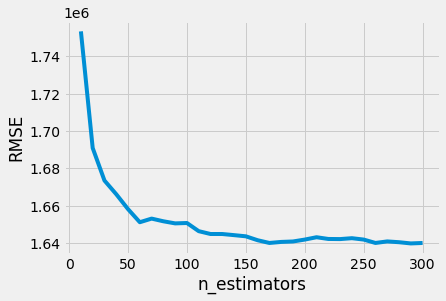

In [22]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [23]:
# Selección de variables predictoras
feature_cols = data.columns.drop('Price')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [24]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols) + 1)

# Definición de lista para almacenar el error cuadrático medio (RMSE) promedio para cada valor de max_features
rmse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf_reg = RandomForestRegressor(n_estimators=290, max_features=feature, random_state=1, n_jobs=-1)
    rmse_scores.append(-1 * cross_val_score(rf_reg, X, y, cv=10, scoring='neg_mean_squared_error').mean())

# Imprimir los resultados
for i, feature in enumerate(feature_range):
    print(f"max_features={feature}, RMSE promedio={rmse_scores[i]}")


max_features=1, RMSE promedio=3148938.0323840585
max_features=2, RMSE promedio=3145117.637486185
max_features=3, RMSE promedio=3138337.6910122894
max_features=4, RMSE promedio=3129405.3376870514
max_features=5, RMSE promedio=3117891.8429228505
max_features=6, RMSE promedio=3102334.617047836
max_features=7, RMSE promedio=3081747.559322607
max_features=8, RMSE promedio=3061939.6844476378
max_features=9, RMSE promedio=3044331.0353967506


Estos resultados muestran cómo varía el error cuadrático medio (RMSE) promedio del modelo de Random Forest en función del parámetro `max_features`, que representa el número máximo de características consideradas para dividir un nodo. 

La siguiente gráfica permite visualizar cómo cambia el rendimiento del modelo a medida que varía la cantidad de características consideradas para dividir un nodo.

Text(0, 0.5, 'RMSE')

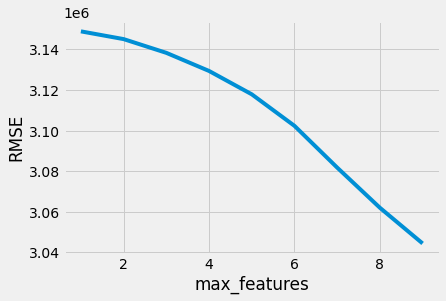

In [25]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')

El siguiente código permite ver qué características son las más importantes para el modelo de Random Forest en términos de su contribución a la predicción:

In [26]:
feature_importance_df=pd.DataFrame({'feature':feature_cols,'importance':rf_model.feature_importances_})
feature_importance_df=feature_importance_df.sort_values('importance', ascending=False)
print(feature_importance_df)

       feature  importance
1      Mileage    0.507278
0         Year    0.387908
3   M_Camry4dr    0.051171
8   M_CamryXLE    0.017414
7    M_CamrySE    0.016900
6    M_CamryLE    0.007295
2      M_Camry    0.007065
5     M_CamryL    0.002920
4  M_CamryBase    0.002048


Las dos características que tienen el mayor impacto en la predicción del precio del automóvil según el modelo son 'Mileage' (millaje) y 'Year' (año).

Ahora, se ajusta el parámetro max_depth del modelo de Random Forest y se evalúa su impacto en el rendimiento utilizando validación cruzada de 10 pliegues:

In [27]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, 15)

# Definición de lista para almacenar el error cuadrático medio (RMSE) promedio para cada valor de max_features
rmse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf_reg = RandomForestRegressor(n_estimators=290, max_features=9, max_depth=feature, random_state=1, n_jobs=-1)
    rmse_scores.append(-1 * cross_val_score(rf_reg, X, y, cv=10, scoring='neg_mean_squared_error').mean())

# Imprimir los resultados
for i, feature in enumerate(feature_range):
    print(f"max_depth={feature}, RMSE promedio={rmse_scores[i]}")


max_depth=1, RMSE promedio=6535277.2727508
max_depth=2, RMSE promedio=4221238.958422023
max_depth=3, RMSE promedio=3368182.5409630984
max_depth=4, RMSE promedio=2882017.9153422923
max_depth=5, RMSE promedio=2603674.9735049363
max_depth=6, RMSE promedio=2452884.0619794866
max_depth=7, RMSE promedio=2370611.159913721
max_depth=8, RMSE promedio=2344615.2401487483
max_depth=9, RMSE promedio=2354950.7108524693
max_depth=10, RMSE promedio=2389225.7920586327
max_depth=11, RMSE promedio=2436943.0904119625
max_depth=12, RMSE promedio=2496050.8857918484
max_depth=13, RMSE promedio=2561020.190119169
max_depth=14, RMSE promedio=2629159.881488559


Los resultados muestran cómo varía el error cuadrático medio (RMSE) promedio del modelo de Random Forest en función del parámetro `max_depth`, que representa la profundidad máxima de los árboles en el bosque.

Se observa que, a medida que aumenta el valor de `max_depth`, el RMSE promedio disminuye, sin embargo, después de que  `max_depth=7`, el RMSE promedio comienza a aumentar nuevamente. Esto indica que permitir una profundidad excesiva puede conducir a un sobreajuste del modelo, donde el modelo se ajusta demasiado a los datos de entrenamiento y tiene dificultades para generalizar a nuevos datos. En este caso, el valor más bajo de RMSE promedio se encuentra cuando `max_depth=8`, luego, es en este valor donde se tiene un equilibrio entre la capacidad predictiva del modelo y la prevención del sobreajuste.

 continuación se presenta una gráfica que permite visualizar cómo cambia el rendimiento del modelo a medida que varía la profundidad máxima de los árboles en el bosque:

Text(0, 0.5, 'RMSE')

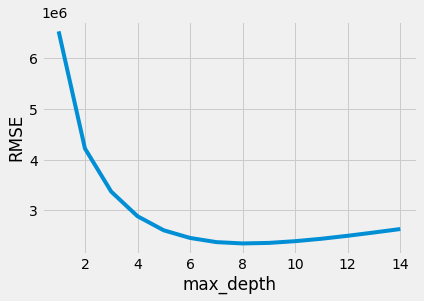

In [28]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

El siguiente código proporciona el RMSE del modelo de Random Forest con los mejores parámetros encontrados, lo cual, permite evaluar su desempeño en los datos de prueba.

In [29]:
rf_model = RandomForestRegressor(n_estimators=290, max_features=9, max_depth=8, random_state=42)

# Entrena el modelo Random Forest
rf_model.fit(X_train, y_train)

# Predice los valores de prueba
y_pred = rf_model.predict(X_test)

# Calcula y muestra el error cuadrático medio (RMSE)
rmse5 = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"El error cuadrático medio (RMSE) del modelo Random Forest con los mejores parametros es: {rmse5:.4f}")

El error cuadrático medio (RMSE) del modelo Random Forest con los mejores parametros es: 1588.8822


### Desempeño del modelo y análisis de parámetros

Al realizar una calibración de los parámetros max_depth, max_features y n_estimators se pudo ver una mejora consireable en el desempeño del modelo, ya que el rmse se redujo hasta 1588.5773, lo cual es el mejor desempeño obtenido hasta el momento. 

La forma en la que cada parámetro afecta el desempeño del modelo es la siguiente:

n_estimators: Aumentar el numero de árboles mejora el desempeño del modelo hasta cierto punto hasta llegar a un maximo que no reduce mas el error.

max_depth: Es la profundidad maxima de cada árbol. Si es un valor muy bajo hace el modelo demasiado simple y lleva al subajuste, mientras que un valor muy alto puede llevar al overfitting ya que el modelo sería muy complejo. Es por esto que se debe encontrar un valor medio que de el error mas bajo.

max_features: Son el número máximo de características consideradas. Un valor bajo tiende a aumentar la diversidad entre los árboles de modo que el desempeño mejore y se evite el sobreajuste. Un valor alto puede aumentar el riesgo a sobreajuste


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [30]:
# Celda 6
!pip install xgboost
from xgboost import XGBRegressor

# Crear un modelo de XGBRegressor con los parámetros deseados
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

# Predicción usando el modelo entrenado
y_pred = xgb_reg.predict(X_test)

# Calcular y mostrar el error cuadrático medio (RMSE)
rmse6 = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"El error cuadrático medio (RMSE) del modelo XGBoost es: {rmse6}")

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 325.1 kB/s eta 0:05:07
   ---------------------------------------- 0.1/99.8 MB 573.4 kB/s eta 0:02:54
   ---------------------------------------- 0.5/99.8 MB 2.9 MB/s eta 0:00:35
    --------------------------------------- 2.1/99.8 MB 9.1 MB/s eta 0:00:11
   - -------------------------------------- 3.5/99.8 MB 12.5 MB/s eta 0:00:08
   - -------------------------------------- 4.0/99.8 MB 12.1 MB/s eta 0:00:08
   - -------------------------------------- 4.9/99.8 MB 13.1 MB/s eta 0:00:08
   -- ------------------------------------- 6.4/99.8 MB 15.2 MB/s eta 0:00:07
   --- ------------------------------------ 7.8/99.8 MB 16.6 MB/s eta 0:00:06
   --- ------------------------------------ 9.2/99.8 MB 17.8 MB/s eta 0:00:06
   ---- --

### Desempeño del modelo

Se puede ver que con el modelo XGBoost con librería se obtiene un rmse de 1653.368885851116, un valor sorprendentemente bajo teniendo en cuenta que no se ha realizado aún la calibración de parámetros, lo que indica que el modelo tiene un buen rendimiento en la predicción de los precios de los automóviles en el conjunto de datos de prueba.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

modelo = xgb.XGBRegressor(objective='reg:squarederror')

parametros = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'colsample_bytree': [0.1, 0.3, 0.5, 0.8],
    'gamma': [0, 0.1, 0.3, 0.5]

}

grid_search_xgb = GridSearchCV(estimator=modelo, param_grid=parametros, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

print("Mejores parametros:", grid_search_xgb.best_params_)

mejor_modelo = grid_search_xgb.best_estimator_

y_pred = mejor_modelo.predict(X_test)
rmse7 = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE en conjunto de prueba con los mejores parámetros: {rmse7}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Mejores parametros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1}
RMSE en conjunto de prueba con los mejores parámetros: 1569.9506902534658


### Desempeño del modelo y análisis de parámetros

Se puede apreciar que luego de la calibración de parámetros el desempeño del modelo aumentó, obteniendo un rmse de 1569.488870078393

La forma en la que cada parámetro afecta el desempeño del modelo es la siguiente:

learning_rate: Se trata de la tasa de aprendizaje. Cuando el valor es mas bajo el aprendizaje es mas lento, por lo que requiere un mayor número de árboles. Si el valor es muy alto hay un alto riesgo de sobreajuste. Se debe encontrar un valor que vaya de acuerdo al numero de árboles.

colsample_bytree: Selecciona un subconjunto de caracteristicas para construir cada árbol. Un valor bajo aumenta la diversidad entre árboles, suele hacer el modelo mas robusto pero si hay muy pocas características lleva al subajuste. Un valor alto hace que cada árbol sea mas preciso, pero al reducir la variabilidad hay un mayor riesgo de sobreajuste.

gamma: Tiene la función de controlar la regularización. Un valor bajo hará que los árboles sean mas complejos, incrementando el riesgo de sobreajuste. Un valor alto hace que los árboles sean mas simples y sirve para evitar el sobreajuste, sin embargo si es muy alto puede llevar a subajuste. Se debe buscar un valor medio.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

A continuación se presenta un gráfico de barras, donde cada barra representa el RMSE de un modelo específico. Los modelos se comparan tanto antes como después de la calibración de parámetros.

El modelo con el RMSE más bajo se resalta en rojo. En este caso, el modelo XGBoost calibrado parece ser el mejor entre los modelos presentados.

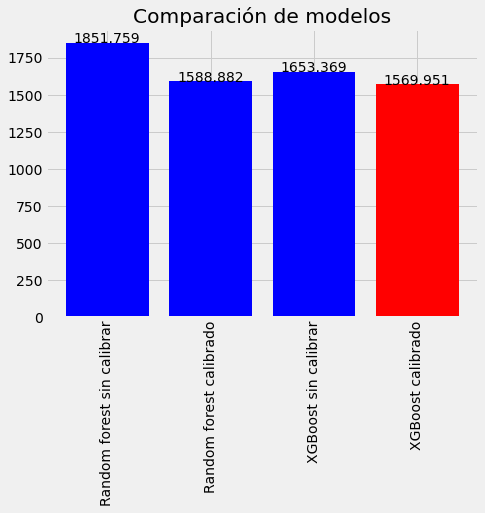

In [32]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Comparación de modelos")
ejeX = ['Random forest sin calibrar', 'Random forest calibrado', 'XGBoost sin calibrar', 'XGBoost calibrado']
ejeY = [rmse4, rmse5, rmse6, rmse7]

min_rmse_index = ejeY.index(min(ejeY))

colors = ['blue' if i != min_rmse_index else 'red' for i in range(len(ejeY))]

ax.bar(ejeX, ejeY, color=colors)

def addlabels(x, y, plotP):
    for i in range(len(x)):
        plotP.text(i, y[i], f"{y[i]:.3f}", ha='center')

addlabels(ejeX, ejeY, plt)

plt.xticks(rotation=90)

plt.show()


Como se puede ver en el gráfico comparativo el modelo que obtuvo el menor error fue el XGBoost con calibración de parámetros, sin embargo el modelo de random forest tuvo un rmse muy cercano. Es evidente que en ambos modelos la calibración de parámetros ayudó considerablemente a mejorar el desempeño. En cuanto a los modelos, las ventajas que tiene el XGBoost sobre el random forest son la regularización, la validación cruzada y el soporte de valores nulos. Además de lo anterior el modelo XGBoost tiene una gran optimización y supone una menor carga computacional para el sistema. Las desventajas del random forest, en el caso de estar sin calibrar es su tendencia al overfitting, además es más costoso computacionalmente, por lo que es más lento realizando predicciones.

Es por esta razón que en este caso el modelo XGBoost es el mejor en todos los aspectos y sería la opción recomendable para realizar predicciones con este conjunto de datos.